<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/PCam_110k_uneven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Data is a modified version of the PCam dataset--duplicates have been removed. The goal is to classify the images as cancerous or non-cancerous. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
https://www.kaggle.com/c/histopathologic-cancer-detection/data?select=train_labels.csv 

###Acknowledgements
Code was adapted from the following sources:

Deep Learning with Python by Francis Chollet

https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch


#Setup and Preprocessing

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set(style="whitegrid")

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import os, random
from random import shuffle
import cv2 #image processing
from glob import glob #for easily finding matching filenames 
from tqdm import tqdm, tqdm_notebook, trange #progress bar
import gc #garbage collection, for saving RAM

import tensorflow as tf
from tensorflow import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0-tf'

In [2]:
from keras import metrics
from keras import models
from keras import layers

Using TensorFlow backend.


##Upload data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Code executed once to unzip the files, then commented out:

In [0]:
# #unzip set of training files (smaller dataset to make sure it works)
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/sampleTrain.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain"

In [4]:
#Check whether sample files are readable
sample_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain/sampleTrain')
print(f'{len(sample_names)} files in sample directory')
print(sample_names[:5])

10 files in sample directory
['00a0ad1de2cdf805f02c524a985bca5bce1d1b5f.tif', '0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif', '0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif', '0a0d1a09e5cf9fcc308ecdc210450aecd204d344.tif', '0a0b4604d66cecfe668e26383c22fafb74484eef.tif']


Started with 10,000 training files in order develop model

Be sure to change path below when adding more files

In [5]:
#unzip set of training files
!unzip -uq "/content/drive/My Drive/MSDS 458/PCam/train110P.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/train"

          No such file or directory


In [0]:
# drive.mount("/content/drive", force_remount=True)

In [6]:
#Check whether sample files are readable
train_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/train/train110P')
print(f'{len(train_names)} files in training directory')
print(train_names[:5])

109104 files in training directory
['6c1f0477cd23d1ba4adf36bc77b510ab3e4597a4.tif', '023f48b947a947fffd4396db4358401cf423a919.tif', '9bb3ce91e19ba3158ba8ff7340f8003a4a2ac084.tif', '17aefb86a10ae4f6f71e259f34bbc34648ed0713.tif', '8e54ac7bb39fecf0ff4617a829efdca0e6fadab4.tif']


Code below to unzip testing data. It has not been run yet it order to save space on Drive.

In [0]:
# #unzip set of testing files 
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/test.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/test"

In [0]:
# #Check whether sample files are readable
# test_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/test')
# print(f'{len(test_names)} files in testing directory')
# print(test_names[:5])

##Set paths

In [0]:
path = '/content/drive/My Drive/MSDS 458/PCam/unzipped/'
train_path = path+'train/train110P'
test_path =  path+'test/'
sample_path = path+'sampleTrain/sampleTrain'  #contains 10 images, simply for testing data can be read

##Load labels and filenames

In [0]:
labels = pd.read_csv('/content/drive/My Drive/MSDS 458/PCam/train_labels.csv')

In [9]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[9].split(".")[0]) # keep only the file names in 'id'
df.head()

,path,id
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6c1f0477cd23d1ba4adf36bc77b510ab3e4597a4
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,023f48b947a947fffd4396db4358401cf423a919
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9bb3ce91e19ba3158ba8ff7340f8003a4a2ac084
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,17aefb86a10ae4f6f71e259f34bbc34648ed0713
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,8e54ac7bb39fecf0ff4617a829efdca0e6fadab4


In [0]:
df = df.merge(labels, on = "id") # merge labels and filepaths

In [11]:
df.head(5) # print the first five entries

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6c1f0477cd23d1ba4adf36bc77b510ab3e4597a4,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,023f48b947a947fffd4396db4358401cf423a919,1
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9bb3ce91e19ba3158ba8ff7340f8003a4a2ac084,1
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,17aefb86a10ae4f6f71e259f34bbc34648ed0713,0
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,8e54ac7bb39fecf0ff4617a829efdca0e6fadab4,0


In [12]:
print(df.count) #check total number of rows in dataframe

<bound method DataFrame.count of                                                      path  ... label
0       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
1       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
2       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
3       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
4       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
...                                                   ...  ...   ...
109098  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
109099  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
109100  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
109101  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
109102  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0

[109103 rows x 3 columns]>


In [16]:
df['label'].value_counts()

0    64978
1    44125
Name: label, dtype: int64

In [20]:
64978/109103
#44125/109103

0.5955656581395562

Did not balance out the classes, retained 60:40 ratio

##Balancing out classes, since 40% are in class 1

In [13]:
# create dataframe with all of the class 1 samples
df_1 = df[df['label']==1]
sample_size = len(df_1)
sample_size

44125

In [0]:
# take a random sample of class 0 that is equal to the number of samples in class 1
df_0 = df[df['label']==0].sample(sample_size, random_state = 42)

In [15]:
# concatenate the dataframes
df_equal = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_equal['label'].value_counts()

1    44125
0    44125
Name: label, dtype: int64

In [138]:
df_equal.head()

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,4cf42ad0c370104b7cd2f21ec66b4090b14ce926,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,2d6d848a6c96d40a60220a54b0a44f742535bd1b,0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,86e527fe4f1b6e36f5b9a04089f7c645bf15b453,0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,5fd5eb8d5785411a7f91374393133fd53ccf55b6,0
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,3fcab672147042d87357062efaaafe9b4179e9eb,0


##Load images

In [0]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,40,40,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    dfLabel=df['label']
    y = np.squeeze(dfLabel.to_numpy())[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    # Scale the data to [0,1] interval
    X = X.astype('float16')/255      #comment out to perform EDA steps
    return X,y

In [0]:
# Load some of the images
N=10000
X,y = load_data(N=N,df=df) #this is from dataframe that is not uniformly distributed, but is shuffled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


##EDA

View some sample images. Non-cancerous samples are labeled 0, and cancerous samples are labeled 1.

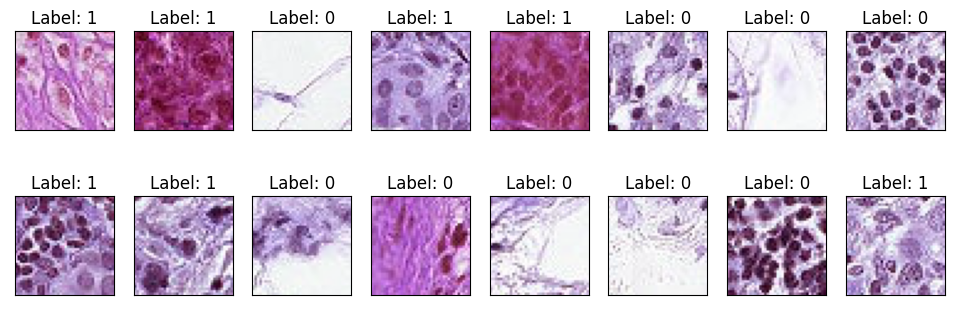

In [0]:
fig = plt.figure(figsize=(12, 4), dpi=100)
np.random.seed(777) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,16)):
    ax = fig.add_subplot(2, 16//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

Evaluate the distribution of the two classes

Text(0, 0.5, 'Samples')

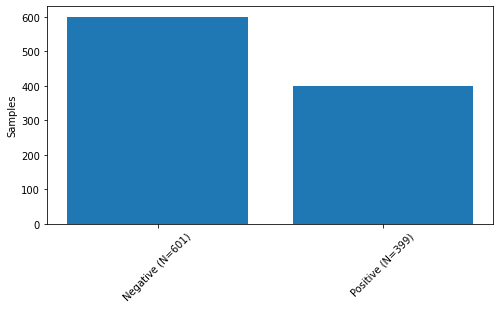

In [0]:
plt.figure(figsize=[8,4])
plt.bar([0,1], [(y==0).sum(), (y==1).sum()])
plt.axis()
plt.xticks([0,1],[f"Negative (N={(y==0).sum()})",f"Positive (N={(y==1).sum()})"],rotation=45)
#plt.xticks(rotation=45)
#plt.rc('xtick',labelsize=10)
plt.ylabel('Samples')


In [0]:
print(f"{round((y==1).sum()/len(y)*100,2)}% of the samples are positive.") 
print(f"We need to clear the baseline of {round((y==0).sum()/len(y)*100,2)}%, which would be the accuracy if we predicted that all of the samples were non-cancerous.")

39.9% of the samples are positive.
We need to clear the baseline of 60.1%, which would be the accuracy if we predicted that all of the samples were non-cancerous.


###To evaluate the classes individually

In [0]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Look at the distribution of the pixels for each color channel

In [0]:
# nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
# fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

# #RGB channels
# axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
# axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

# #All channels
# axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
# axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

# #Set image labels
# axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
# axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
# axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
# axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
# axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
# axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
# for i in range(4):
#     axs[i,0].set_ylabel("Relative frequency")
# axs[3,0].set_xlabel("Pixel value")
# axs[3,1].set_xlabel("Pixel value")
# fig.tight_layout()

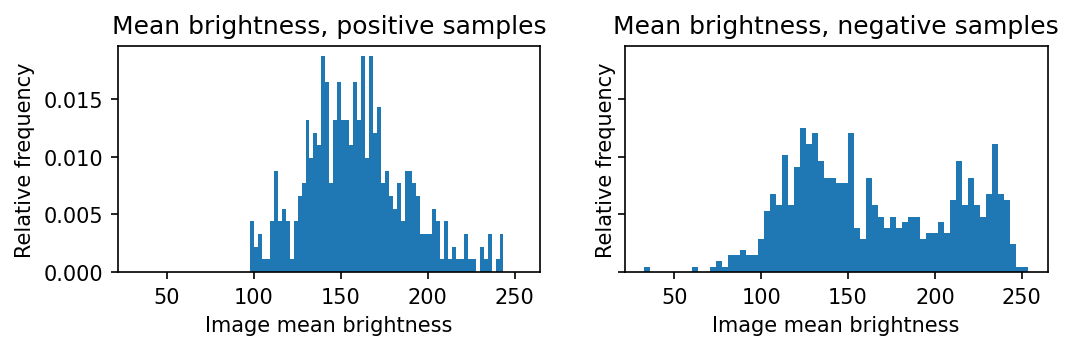

In [0]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

In [0]:
#Clean up variables to free up RAM
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

#Prepare data for modeling

In [0]:
#Load remainder of dataset
X_equal = None
y_equal = None
gc.collect();
#using df with same number of samples per class
N = df_equal["path"].size # get the number of images in the training data set
X_equal,y_equal = load_data(N=N,df=df_equal)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
X_equal[1]

In [0]:
#Load remainder of dataset
X_ = None
y = None
gc.collect();
#using df with same number of samples per class
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)

In [23]:
X[1]

array([[[0.604 , 0.3647, 0.655 ],
        [0.686 , 0.4392, 0.7295],
        [0.655 , 0.3882, 0.6904],
        ...,
        [0.4746, 0.2079, 0.4626],
        [0.643 , 0.396 , 0.6665],
        [0.643 , 0.408 , 0.686 ]],

       [[0.702 , 0.4863, 0.7725],
        [0.6587, 0.443 , 0.753 ],
        [0.698 , 0.4785, 0.8037],
        ...,
        [0.4746, 0.1843, 0.4119],
        [0.612 , 0.3098, 0.6   ],
        [0.698 , 0.396 , 0.7256]],

       [[0.5605, 0.2744, 0.549 ],
        [0.686 , 0.4197, 0.7217],
        [0.682 , 0.4392, 0.7607],
        ...,
        [0.937 , 0.6943, 0.8823],
        [0.5806, 0.2825, 0.565 ],
        [0.506 , 0.1647, 0.51  ]],

       ...,

       [[0.7725, 0.5176, 0.816 ],
        [0.8745, 0.6353, 0.886 ],
        [0.7217, 0.51  , 0.6943],
        ...,
        [0.541 , 0.2903, 0.5728],
        [0.682 , 0.4   , 0.7217],
        [0.796 , 0.5176, 0.8315]],

       [[0.5923, 0.3215, 0.6353],
        [0.6904, 0.4275, 0.7217],
        [0.7686, 0.5254, 0.784 ],
        .

##Train test split

In [0]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
#not setting a random_state and not shuffling because samples are already shuffled and want to save RAM 
# added random state instead of shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X_equal, y_equal, test_size=0.2, random_state=42)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((87282, 40, 40, 3), (21821, 40, 40, 3), (87282,), (21821,))

In [0]:
# X = None
# y = None
# gc.collect();

#Define callbacks for training/testing times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

#Experiment 1:DNN
Establish a baseline with a simple two layer DNN.

##Build and compile the model

In [32]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(40, 40, 3)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               960200    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 980,401
Trainable params: 980,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [34]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 74189 samples, validate on 13093 samples
Epoch 1/15
74189/74189 [==============================] - 7s 101us/step - loss: 0.6571 - accuracy: 0.5988 - val_loss: 0.6493 - val_accuracy: 0.6051
Epoch 2/15
74189/74189 [==============================] - 7s 95us/step - loss: 0.6290 - accuracy: 0.6248 - val_loss: 0.6158 - val_accuracy: 0.6747
Epoch 3/15
74189/74189 [==============================] - 7s 96us/step - loss: 0.6218 - accuracy: 0.6426 - val_loss: 0.6272 - val_accuracy: 0.6389
Epoch 4/15
74189/74189 [==============================] - 7s 94us/step - loss: 0.6158 - accuracy: 0.6546 - val_loss: 0.6024 - val_accuracy: 0.6914
Epoch 5/15
74189/74189 [==============================] - 7s 96us/step - loss: 0.6051 - accuracy: 0.6740 - val_loss: 0.5897 - val_accuracy: 0.7017
Epoch 6/15
74189/74189 [==============================] - 7s 95us/step - loss: 0.5955 - accuracy: 0.6875 - val_loss: 0.5922 - val_accuracy: 0.6978
Epoch 7/15
74189/74189 [==============================] - 7s 95us/s

In [35]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

106.095547

##Test the model

In [36]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

21821/21821 [==============================] - 2s 109us/step


(0.5635552606204162, 0.705054759979248)

In [37]:
test_time = test_rt.process_time
test_time # in seconds

2.373982

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

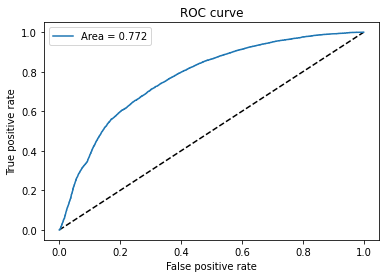

In [40]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Create a dataframe for the training and test statistics

In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [42]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,val_loss,val_accuracy,loss,accuracy
10,0.580671,0.697243,0.564724,0.711898
11,0.548213,0.728481,0.560252,0.715632
12,0.584688,0.699916,0.559254,0.716360
13,0.544010,0.725197,0.555298,0.718624
14,0.559548,0.707936,0.552402,0.722641


In [43]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layer)') 
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['auroc'] = auc_keras
results_df['train time'] = train_time    
results_df['test time'] = test_time    
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,DNN (1 layer),0.559548,0.707936,0.552402,0.722641,0.563555,0.705055,0.772416,106.095547,2.373982


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

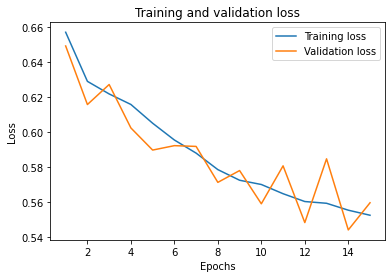

In [44]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

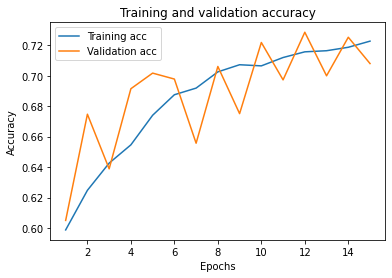

In [45]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Experiment 2: DNN

This model is the same as in Experiment 1, but with a batch size of 1000 instead of 100.

First hidden layer has 200 nodes, second hidden layer has 100 nodes.

##Build and compile the model

In [48]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(40, 40, 3)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               960200    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 980,401
Trainable params: 980,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [50]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=20,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 74189 samples, validate on 13093 samples
Epoch 1/20
74189/74189 [==============================] - 3s 45us/step - loss: 0.8174 - accuracy: 0.5727 - val_loss: 0.6340 - val_accuracy: 0.6149
Epoch 2/20
74189/74189 [==============================] - 3s 42us/step - loss: 0.6369 - accuracy: 0.6058 - val_loss: 0.6279 - val_accuracy: 0.5932
Epoch 3/20
74189/74189 [==============================] - 3s 42us/step - loss: 0.6295 - accuracy: 0.6197 - val_loss: 0.6171 - val_accuracy: 0.6525
Epoch 4/20
74189/74189 [==============================] - 3s 41us/step - loss: 0.6209 - accuracy: 0.6326 - val_loss: 0.6166 - val_accuracy: 0.6699
Epoch 5/20
74189/74189 [==============================] - 3s 42us/step - loss: 0.6112 - accuracy: 0.6435 - val_loss: 0.6137 - val_accuracy: 0.6633
Epoch 6/20
74189/74189 [==============================] - 3s 42us/step - loss: 0.6067 - accuracy: 0.6508 - val_loss: 0.5969 - val_accuracy: 0.6515
Epoch 7/20
74189/74189 [==============================] - 3s 41us/st

In [51]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

61.739594

##Test the model

In [52]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

21821/21821 [==============================] - 2s 107us/step


(0.5651437789604636, 0.7003803849220276)

In [53]:
test_time = test_rt.process_time
test_time # in seconds

2.333252

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

###ROC and AUROC

In [0]:
auc_keras = auc(fpr, tpr)

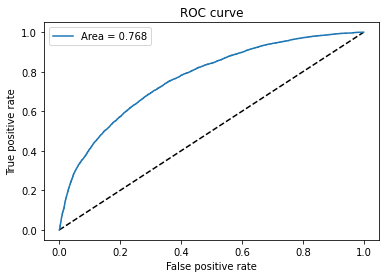

In [56]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [58]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layer dropout)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
19,DNN (2 layer dropout),0.561467,0.702284,0.562098,0.712788,0.565144,0.70038,0.767841,61.739594,2.333252


In [59]:
results_df=results_df.append(df,ignore_index=True)
results_df


,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.559548,0.707936,0.552402,0.722641,0.563555,0.705055,0.772416,106.095547,2.373982
1,DNN (2 layer dropout),0.561467,0.702284,0.562098,0.712788,0.565144,0.700380,0.767841,61.739594,2.333252


### Plotting the performance 


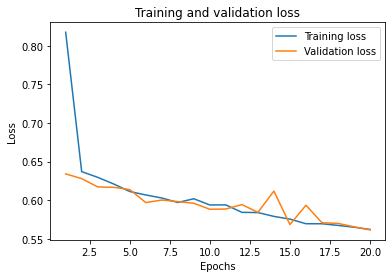

In [60]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

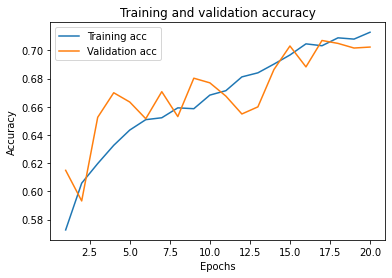

In [61]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 3: CNN with 2 convolutional layers, batchsize 100

In [64]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)             

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [66]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 74189 samples, validate on 13093 samples
Epoch 1/15
74189/74189 [==============================] - 20s 268us/step - loss: 0.5284 - accuracy: 0.7394 - val_loss: 0.4825 - val_accuracy: 0.7806
Epoch 2/15
74189/74189 [==============================] - 15s 197us/step - loss: 0.4744 - accuracy: 0.7817 - val_loss: 0.4428 - val_accuracy: 0.7991
Epoch 3/15
74189/74189 [==============================] - 14s 195us/step - loss: 0.4620 - accuracy: 0.7894 - val_loss: 0.4391 - val_accuracy: 0.8059
Epoch 4/15
74189/74189 [==============================] - 14s 195us/step - loss: 0.4462 - accuracy: 0.8000 - val_loss: 0.4353 - val_accuracy: 0.8046
Epoch 5/15
74189/74189 [==============================] - 14s 194us/step - loss: 0.4387 - accuracy: 0.8034 - val_loss: 0.4319 - val_accuracy: 0.8063
Epoch 6/15
74189/74189 [==============================] - 14s 195us/step - loss: 0.4298 - accuracy: 0.8085 - val_loss: 0.4082 - val_accuracy: 0.8223
Epoch 7/15
74189/74189 [==============================] 

In [67]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

222.161261

##Test the model

In [68]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

21821/21821 [==============================] - 3s 148us/step


(0.39425585246409534, 0.8251684308052063)

In [69]:
test_time = test_rt.process_time
test_time # in seconds

3.231783

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

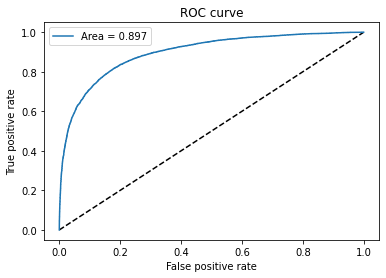

In [72]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [73]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers, batch100)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"CNN (2 layers, batch100)",0.389382,0.831819,0.376506,0.837227,0.394256,0.825168,0.896671,222.161261,3.231783


In [74]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.559548,0.707936,0.552402,0.722641,0.563555,0.705055,0.772416,106.095547,2.373982
1,DNN (2 layer dropout),0.561467,0.702284,0.562098,0.712788,0.565144,0.700380,0.767841,61.739594,2.333252
2,"CNN (2 layers, batch100)",0.389382,0.831819,0.376506,0.837227,0.394256,0.825168,0.896671,222.161261,3.231783


### Plotting the performance 


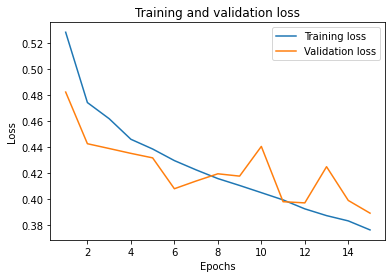

In [75]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

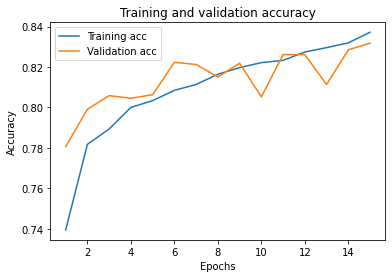

In [76]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 4: CNN with 2 convolutional layers, dropout

In [77]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4096)             

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [79]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 74189 samples, validate on 13093 samples
Epoch 1/15
74189/74189 [==============================] - 10s 130us/step - loss: 0.6431 - accuracy: 0.6182 - val_loss: 0.5735 - val_accuracy: 0.7050
Epoch 2/15
74189/74189 [==============================] - 9s 117us/step - loss: 0.5140 - accuracy: 0.7615 - val_loss: 0.5269 - val_accuracy: 0.7459
Epoch 3/15
74189/74189 [==============================] - 9s 116us/step - loss: 0.4973 - accuracy: 0.7709 - val_loss: 0.5047 - val_accuracy: 0.7616
Epoch 4/15
74189/74189 [==============================] - 9s 116us/step - loss: 0.4891 - accuracy: 0.7744 - val_loss: 0.4754 - val_accuracy: 0.7833
Epoch 5/15
74189/74189 [==============================] - 9s 116us/step - loss: 0.4834 - accuracy: 0.7792 - val_loss: 0.5099 - val_accuracy: 0.7652
Epoch 6/15
74189/74189 [==============================] - 9s 115us/step - loss: 0.4731 - accuracy: 0.7848 - val_loss: 0.4994 - val_accuracy: 0.7677
Epoch 7/15
74189/74189 [==============================] - 9s 

In [80]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

130.252183

##Test the model

In [81]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

21821/21821 [==============================] - 3s 138us/step


(0.4867650343953763, 0.7827780842781067)

In [82]:
test_time = test_rt.process_time
test_time # in seconds

3.018583

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

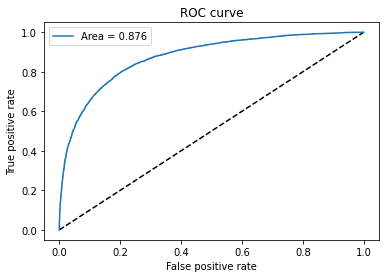

In [85]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
# results_df = history_df.iloc[-1:].copy()
# results_df.insert(0,'model','VGG16, 6 thawed batch100') 
# results_df['test_loss'] = test_loss #incorporate test results
# results_df['test_accuracy'] = test_acc
# results_df['auroc'] = auc_keras
# results_df['train time'] = train_time    
# results_df['test time'] = test_time    
# results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed batch100",0.462399,0.79,0.398716,0.834118,0.511062,0.8015,0.876494,39.586958,0.565562


In [86]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers, batch1000)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"CNN (2 layers, batch1000)",0.476631,0.785,0.427663,0.811077,0.486765,0.782778,0.875569,130.252183,3.018583


In [87]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.559548,0.707936,0.552402,0.722641,0.563555,0.705055,0.772416,106.095547,2.373982
1,DNN (2 layer dropout),0.561467,0.702284,0.562098,0.712788,0.565144,0.700380,0.767841,61.739594,2.333252
2,"CNN (2 layers, batch100)",0.389382,0.831819,0.376506,0.837227,0.394256,0.825168,0.896671,222.161261,3.231783
3,"CNN (2 layers, batch1000)",0.476631,0.785000,0.427663,0.811077,0.486765,0.782778,0.875569,130.252183,3.018583


### Plotting the performance 


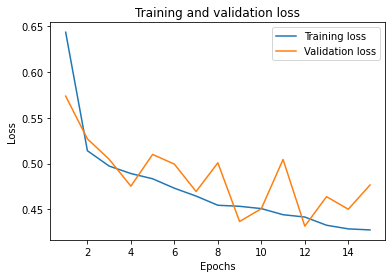

In [88]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

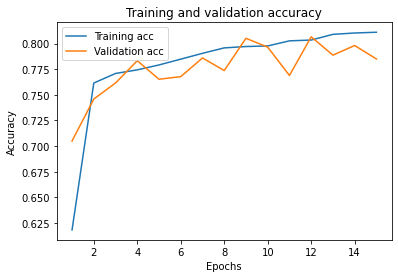

In [89]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###Confusion matrix
True (row) and predicted (column) values

In [0]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [91]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[39125, 12842],
       [ 5667, 29648]])

#Feature Extraction

In [0]:
train_names[3]

'37f0d8cc90045cfe381b8000b8fbc5637c564778.tif'

In [0]:
# map sample image to array
img_path = train_path + '/' + train_names[3]

from keras.preprocessing import image                             

img = image.load_img(img_path, target_size=(40, 40))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                                
print(img_tensor.shape)  

(1, 40, 40, 3)


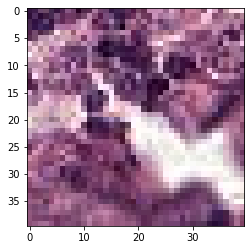

In [0]:
# display sample image
plt.imshow(img_tensor[0])
plt.show()

In [0]:
# instantiate a model from an input tensor and list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activations = activation_model.predict(img_tensor)

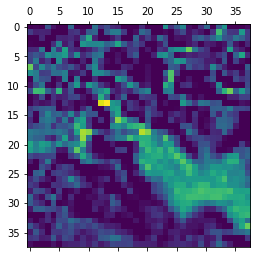

In [0]:
# activation of the first convolution layer for the sample image input
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

In [0]:
# every channel in every intermediate activation
layer_names = []                                                          
for layer in model.layers[:8]:                                            
    layer_names.append(layer.name)                                        

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):        
    n_features = layer_activation.shape[-1]                               

    size = layer_activation.shape[1]                                      

    n_cols = n_features // images_per_row                                 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):                                             
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()                         
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                   
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


#Export Results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam110k_cnnEqual.csv')
files.download('PCam110k_cnnEqual.csv')

#Pre-trained Network: VGG16

In [0]:
from keras.applications import VGG16

## VGG16 3 layers thawed

###Instantiate the model

Do not use dropout initially

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 17s 310us/step - loss: 0.4729 - accuracy: 0.7848 - val_loss: 0.4289 - val_accuracy: 0.8045
Epoch 2/15
54400/54400 [==============================] - 16s 298us/step - loss: 0.4146 - accuracy: 0.8130 - val_loss: 0.4086 - val_accuracy: 0.8130
Epoch 3/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3969 - accuracy: 0.8210 - val_loss: 0.3999 - val_accuracy: 0.8195
Epoch 4/15
54400/54400 [==============================] - 16s 298us/step - loss: 0.3754 - accuracy: 0.8327 - val_loss: 0.4004 - val_accuracy: 0.8201
Epoch 5/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3617 - accuracy: 0.8416 - val_loss: 0.4019 - val_accuracy: 0.8241
Epoch 6/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3448 - accuracy: 0.8483 - val_loss: 0.4156 - val_accuracy: 0.8181
Epoch 7/15
54400/54400 [==============================] -

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

244.583603

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 5s 308us/step


(0.654116459608078, 0.8091874718666077)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

4.925948

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

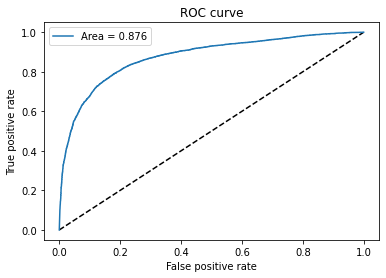

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.588970,0.679271,0.586518,0.689687,0.594717,0.670125,61.349588,1.563415
1,DNN (2 layer dropout),0.567190,0.709271,0.560058,0.709743,0.571902,0.712375,85.752367,1.706699
2,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106
3,"CNN (2 layers, D)",0.406787,0.817083,0.355217,0.846379,0.404930,0.821875,89.789792,1.926839
4,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948


### Plotting the performance 


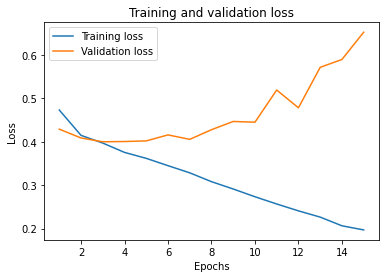

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

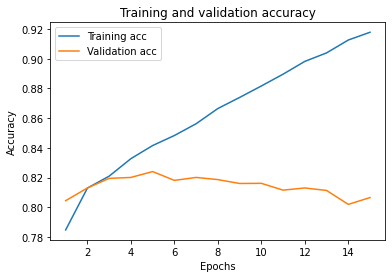

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 3 layers with Dropout

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 52s 950us/step - loss: 0.4571 - accuracy: 0.7900 - val_loss: 0.4183 - val_accuracy: 0.8080
Epoch 2/15
54400/54400 [==============================] - 50s 927us/step - loss: 0.4112 - accuracy: 0.8165 - val_loss: 0.4132 - val_accuracy: 0.8130
Epoch 3/15
54400/54400 [==============================] - 51s 928us/step - loss: 0.3895 - accuracy: 0.8270 - val_loss: 0.4137 - val_accuracy: 0.8117
Epoch 4/15
54400/54400 [==============================] - 50s 926us/step - loss: 0.3758 - accuracy: 0.8355 - val_loss: 0.4086 - val_accuracy: 0.8159
Epoch 5/15
54400/54400 [==============================] - 51s 929us/step - loss: 0.3603 - accuracy: 0.8444 - val_loss: 0.4146 - val_accuracy: 0.8173
Epoch 6/15
54400/54400 [==============================] - 50s 927us/step - loss: 0.3472 - accuracy: 0.8497 - val_loss: 0.4234 - val_accuracy: 0.8129
Epoch 7/15
54400/54400 [==============================] -

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

757.410375

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 771us/step


(0.6457765243202448, 0.8058750033378601)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

12.342323

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

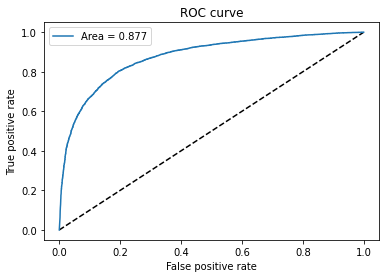

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed, D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 3 thawed, D",0.644842,0.813854,0.21415,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323


### Plotting the performance 


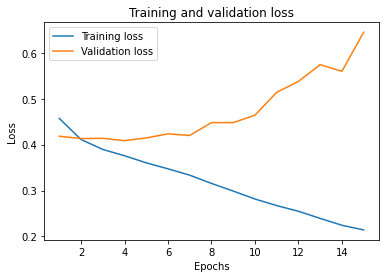

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

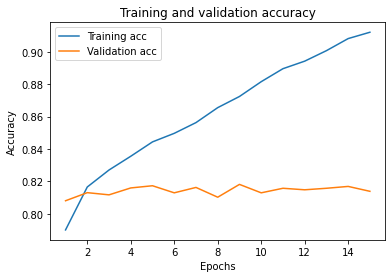

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5) with Dropout batch size 100

In [109]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [112]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 74189 samples, validate on 13093 samples
Epoch 1/15
74189/74189 [==============================] - 99s 1ms/step - loss: 0.4838 - accuracy: 0.7714 - val_loss: 0.3997 - val_accuracy: 0.8269
Epoch 2/15
74189/74189 [==============================] - 97s 1ms/step - loss: 0.4237 - accuracy: 0.8120 - val_loss: 0.4266 - val_accuracy: 0.8075
Epoch 3/15
74189/74189 [==============================] - 97s 1ms/step - loss: 0.4082 - accuracy: 0.8188 - val_loss: 0.3883 - val_accuracy: 0.8328
Epoch 4/15
74189/74189 [==============================] - 96s 1ms/step - loss: 0.3973 - accuracy: 0.8248 - val_loss: 0.3868 - val_accuracy: 0.8269
Epoch 5/15
74189/74189 [==============================] - 96s 1ms/step - loss: 0.3854 - accuracy: 0.8305 - val_loss: 0.3881 - val_accuracy: 0.8285
Epoch 6/15
74189/74189 [==============================] - 96s 1ms/step - loss: 0.3735 - accuracy: 0.8369 - val_loss: 0.3952 - val_accuracy: 0.8309
Epoch 7/15
74189/74189 [==============================] - 97s 1ms/st

In [113]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1448.5407

###Test the model

In [114]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

21821/21821 [==============================] - 16s 742us/step


(0.38077104691487557, 0.8348379731178284)

In [115]:
test_time = test_rt.process_time
test_time # in seconds

16.198645

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

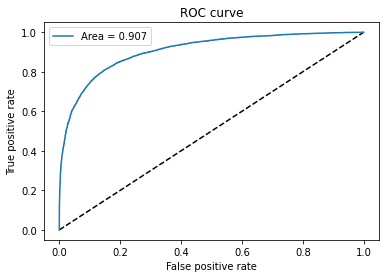

In [118]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [119]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 6 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed",0.386838,0.830978,0.304009,0.872191,0.380771,0.834838,0.907121,1448.5407,16.198645


In [120]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.559548,0.707936,0.552402,0.722641,0.563555,0.705055,0.772416,106.095547,2.373982
1,DNN (2 layer dropout),0.561467,0.702284,0.562098,0.712788,0.565144,0.700380,0.767841,61.739594,2.333252
2,"CNN (2 layers, batch100)",0.389382,0.831819,0.376506,0.837227,0.394256,0.825168,0.896671,222.161261,3.231783
3,"CNN (2 layers, batch1000)",0.476631,0.785000,0.427663,0.811077,0.486765,0.782778,0.875569,130.252183,3.018583
4,"VGG16, 6 thawed batch1000",0.383871,0.845108,0.255307,0.895726,0.382281,0.844966,0.913750,885.789081,16.942884
5,"VGG16, 6 thawed",0.386838,0.830978,0.304009,0.872191,0.380771,0.834838,0.907121,1448.540700,16.198645


### Plotting the performance 


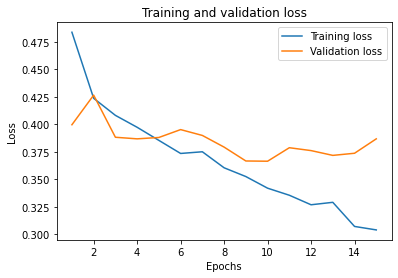

In [121]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

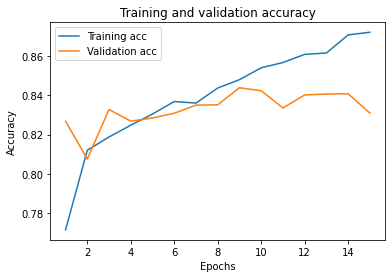

In [122]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5) with Dropout

In [95]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [98]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 74189 samples, validate on 13093 samples
Epoch 1/15
74189/74189 [==============================] - 69s 928us/step - loss: 0.5733 - accuracy: 0.7039 - val_loss: 0.4343 - val_accuracy: 0.8064
Epoch 2/15
74189/74189 [==============================] - 58s 788us/step - loss: 0.4369 - accuracy: 0.8017 - val_loss: 0.4531 - val_accuracy: 0.7934
Epoch 3/15
74189/74189 [==============================] - 58s 787us/step - loss: 0.4087 - accuracy: 0.8160 - val_loss: 0.3827 - val_accuracy: 0.8301
Epoch 4/15
74189/74189 [==============================] - 58s 787us/step - loss: 0.3860 - accuracy: 0.8294 - val_loss: 0.3801 - val_accuracy: 0.8346
Epoch 5/15
74189/74189 [==============================] - 58s 787us/step - loss: 0.3734 - accuracy: 0.8352 - val_loss: 0.3646 - val_accuracy: 0.8417
Epoch 6/15
74189/74189 [==============================] - 58s 786us/step - loss: 0.3626 - accuracy: 0.8417 - val_loss: 0.3613 - val_accuracy: 0.8465
Epoch 7/15
74189/74189 [==============================] 

In [99]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

885.789081

###Test the model

In [100]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

21821/21821 [==============================] - 17s 776us/step


(0.38228106000078055, 0.8449658751487732)

In [101]:
test_time = test_rt.process_time
test_time # in seconds

16.942884

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

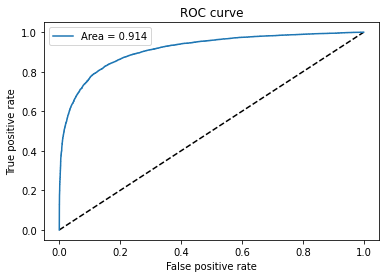

In [104]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [105]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 6 thawed batch1000') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed batch1000",0.383871,0.845108,0.255307,0.895726,0.382281,0.844966,0.91375,885.789081,16.942884


In [106]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.559548,0.707936,0.552402,0.722641,0.563555,0.705055,0.772416,106.095547,2.373982
1,DNN (2 layer dropout),0.561467,0.702284,0.562098,0.712788,0.565144,0.700380,0.767841,61.739594,2.333252
2,"CNN (2 layers, batch100)",0.389382,0.831819,0.376506,0.837227,0.394256,0.825168,0.896671,222.161261,3.231783
3,"CNN (2 layers, batch1000)",0.476631,0.785000,0.427663,0.811077,0.486765,0.782778,0.875569,130.252183,3.018583
4,"VGG16, 6 thawed batch1000",0.383871,0.845108,0.255307,0.895726,0.382281,0.844966,0.913750,885.789081,16.942884


### Plotting the performance 


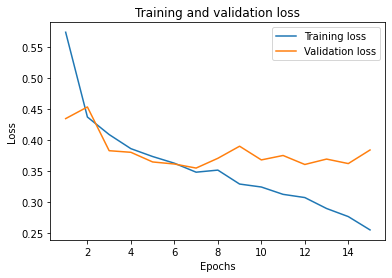

In [107]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

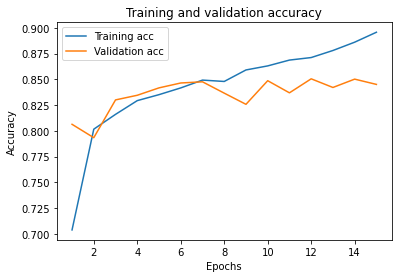

In [108]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 9 convolutional layers (blocks 3, 4, 5)

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 85s 2ms/step - loss: 0.5721 - accuracy: 0.7096 - val_loss: 0.5046 - val_accuracy: 0.7682
Epoch 2/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4898 - accuracy: 0.7746 - val_loss: 0.4724 - val_accuracy: 0.7811
Epoch 3/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4592 - accuracy: 0.7919 - val_loss: 0.4359 - val_accuracy: 0.8048
Epoch 4/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4421 - accuracy: 0.8017 - val_loss: 0.4249 - val_accuracy: 0.8087
Epoch 5/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4196 - accuracy: 0.8138 - val_loss: 0.4495 - val_accuracy: 0.8014
Epoch 6/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4058 - accuracy: 0.8200 - val_loss: 0.4136 - val_accuracy: 0.8213
Epoch 7/15
54400/54400 [==============================] - 84s 2ms/ste

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1260.76891

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 727us/step


(0.3753491099178791, 0.8343124985694885)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

11.634572

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

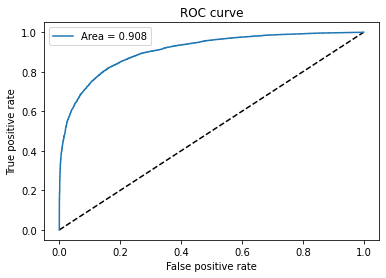

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 9 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.76891,11.634572


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323
3,"VGG16, 6 thawed D",0.396917,0.833854,0.310740,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392
4,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.768910,11.634572


### Plotting the performance 


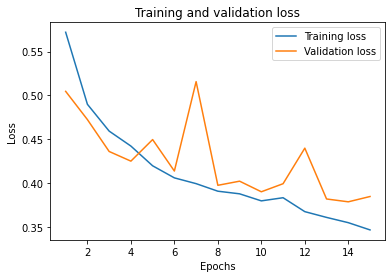

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

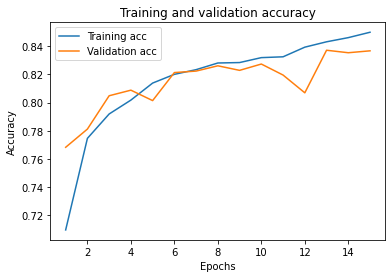

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 9 convolutional layers (blocks 3, 4, 5) with Dropout

In [123]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [126]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 74189 samples, validate on 13093 samples
Epoch 1/15
74189/74189 [==============================] - 73s 989us/step - loss: 0.5678 - accuracy: 0.7087 - val_loss: 0.4929 - val_accuracy: 0.7671
Epoch 2/15
74189/74189 [==============================] - 71s 962us/step - loss: 0.4704 - accuracy: 0.7856 - val_loss: 0.4386 - val_accuracy: 0.8015
Epoch 3/15
74189/74189 [==============================] - 71s 962us/step - loss: 0.4310 - accuracy: 0.8063 - val_loss: 0.4277 - val_accuracy: 0.8033
Epoch 4/15
74189/74189 [==============================] - 71s 962us/step - loss: 0.4099 - accuracy: 0.8175 - val_loss: 0.4318 - val_accuracy: 0.8049
Epoch 5/15
74189/74189 [==============================] - 71s 961us/step - loss: 0.3922 - accuracy: 0.8272 - val_loss: 0.4030 - val_accuracy: 0.8261
Epoch 6/15
74189/74189 [==============================] - 71s 961us/step - loss: 0.3788 - accuracy: 0.8326 - val_loss: 0.3579 - val_accuracy: 0.8442
Epoch 7/15
74189/74189 [==============================] 

In [127]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1072.616889

###Test the model

In [128]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

21821/21821 [==============================] - 16s 738us/step


(0.42906202247302205, 0.8311718106269836)

In [129]:
test_time = test_rt.process_time
test_time # in seconds

16.105031

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

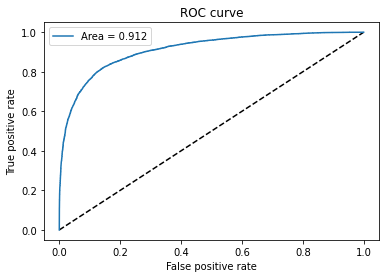

In [132]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [133]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 9 thawed Dropout batch1000') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 9 thawed Dropout batch1000",0.427569,0.834874,0.200942,0.922832,0.429062,0.831172,0.912129,1072.616889,16.105031


In [134]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.559548,0.707936,0.552402,0.722641,0.563555,0.705055,0.772416,106.095547,2.373982
1,DNN (2 layer dropout),0.561467,0.702284,0.562098,0.712788,0.565144,0.700380,0.767841,61.739594,2.333252
2,"CNN (2 layers, batch100)",0.389382,0.831819,0.376506,0.837227,0.394256,0.825168,0.896671,222.161261,3.231783
3,"CNN (2 layers, batch1000)",0.476631,0.785000,0.427663,0.811077,0.486765,0.782778,0.875569,130.252183,3.018583
4,"VGG16, 6 thawed batch1000",0.383871,0.845108,0.255307,0.895726,0.382281,0.844966,0.913750,885.789081,16.942884
5,"VGG16, 6 thawed",0.386838,0.830978,0.304009,0.872191,0.380771,0.834838,0.907121,1448.540700,16.198645
6,"VGG16, 9 thawed Dropout batch1000",0.427569,0.834874,0.200942,0.922832,0.429062,0.831172,0.912129,1072.616889,16.105031


### Plotting the performance 


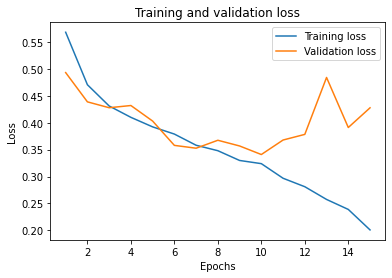

In [135]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

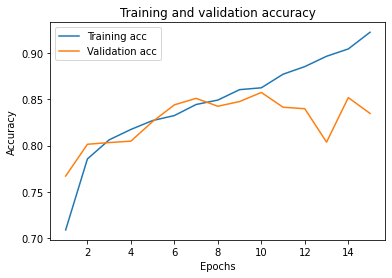

In [136]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Export results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k_resnet.csv')
files.download('PCam80k_resnet.csv')

#Visualizing findings

###Confusion matrix
True (row) and predicted (column) values

In [0]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [0]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[37130,   872],
       [ 1092, 24906]])

#Export results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k_resnet3_6.csv')
files.download('PCam80k_resnet3_6.csv')